### Modeling of Creep

Creep (sometimes called cold flow) is the tendency of a solid material to undergo slow deformation while subject to persistent mechanical stresses. This is common cause of failure in power applications where components are subjected to high thermal and mechanical (pressure) stresses for years, potentially decades. 

Experiments to examine the effects of creep often involve exposing materials to different, isothermal termperatures and a constant state of applided stress, and then measuring the duration required for the component to _fail_. The stress required to achieve failure at some specified time and isothermal temperature is called the _creep rupture stress_ denoted by $S_t$. 

The available creep-rupture stress data is _extremely_ limited for tungsten and tungsten alloys, with the only study coming from Rieth et al. [1]

The Larson-Miller relation is a widely used model for predicting creep behavior. Begining from the assumption that the creep rate follows an Arrhenius process, we can eventually derive the transformation:

$
x = T (C + \ln{t})
$

where $T$ is the temperature, $t$ is the time and $x$ is referred to as the _larson miller parameter_. $C$ is a material dependent constant. We assume that the creep stress has a polynomial dependency on the larson miller parameter:

$
S_t = \sum_{i = 0}^p \beta_i x^i
$

The results fitted to the data are shown below. We can see that the model fits the data well, and the mean square error is only 2 MPa when fitting to the recrystillized tungsten. there are two other experimental results available for only a single temperature (1300 C) for each, one for _un_ recrystillized W and the other for WL10, an alloy of W. the .refit_model() function refits the liner model the larson miller parameter, assuming that $C$ remains constant, which I do here because there's not enough data for these two alloys to refit $C$.

In [3]:
import numpy as np
import pandas as pd
from pathlib import WindowsPath
from matplotlib import pyplot as plt
from common_util import setup_axis_default, LarsonMiller
import copy
import warnings
from matplotlib import rc
import pickle

#ignore warnings and set preference for matplotlib styles
warnings.filterwarnings("ignore")
rc('font',**{'family':'serif','serif':['Times'],'weight': 'bold'})
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = "".join([r"\usepackage{newtxtext,newtxmath}",r"\boldmath"])


def read_w_data() -> pd.DataFrame:
    """
    Read data from the file w_data.csv
    """

    path = WindowsPath('structural_data/creep_data')

    temperature = [873,982,1100,1200,1482]
    data = []
    for temp in temperature:
        df = pd.read_csv(path.joinpath(f'RW_T{temp}C.csv'),header =None)
        df.columns = ['time [hr]','stress [Mpa]']
        df['temperature'] = float(temp) + 273.15
        data.append(df)
    
    return pd.concat(data)

MSE data fit: 2.16


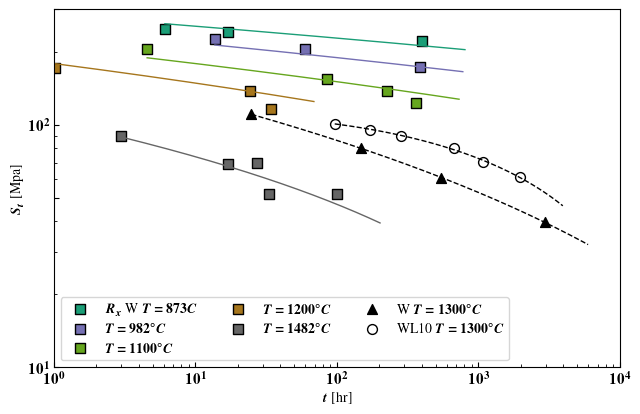

In [6]:
fig,ax = plt.subplots(figsize = (6.5,4.25))
setup_axis_default(ax)

#fit recrystallized tungsten data
df = read_w_data()

rx_model = LarsonMiller()
rx_model.fit(df['time [hr]'].values*3600,
             df['temperature'].values,
             df['stress [Mpa]'].values,
             deg = 2)

mse = np.linalg.norm(rx_model.predict(df['time [hr]'].values*3600,df['temperature'].values) - df['stress [Mpa]'].values)/len(df['stress [Mpa]'])
print(f'MSE data fit: {round(mse,2)}')
with open('.model/creep_larson_miller_rx_w.pkl','wb') as f:
    pickle.dump(rx_model,f)
    
colors = plt.get_cmap('Dark2')(np.linspace(0,1,len(df['temperature'].unique() + 2))) 

# plot recrystallized tungsten data
for temp,color,i in zip(df['temperature'].unique(),colors,range(len(df['temperature'].unique()))):
    sub_df = df[df['temperature'] == temp]

    ax.scatter(sub_df['time [hr]'],sub_df['stress [Mpa]'],
               label = rf'$R_x$ W $T = {round(temp - 273.15)} C$' if i == 0 else rf'$T = {round(temp - 273.15)} ^\circ C$' ,
               facecolor = color,edgecolor = 'k',s = 50,marker = 's')
    
    tplot = np.linspace(sub_df['time [hr]'].min(),sub_df['time [hr]'].max()*2,1000)
    pred_stress = rx_model.predict(tplot*3600,temp*np.ones_like(tplot))
    ax.plot(tplot,pred_stress,linestyle = '-',color = color,lw = 1.0)

#fit & plot unrecrystallized tungsten data
labels = [r'W $T = 1300 ^\circ C$',r'WL10 $T = 1300 ^\circ C$']
print_labels = ['Non-recrystillized W','WL10']

colors = ['k','w']
markers = ['^','o']
for file,label,color,marker,i in zip(['W_T1300C','WL10_1300C'],labels,colors,markers,range(2)):
    un_rx_data = pd.read_csv(f'structural_data/creep_data/{file}.csv',header = None)
    un_rx_data.columns = ['time [hr]','stress [Mpa]']
    un_rx_data['temperature'] = 1300 + 273.15
    un_rx_model = copy.deepcopy(rx_model)   
    un_rx_model.refit_model(un_rx_data['time [hr]'].values*3600,
                un_rx_data['temperature'].values,
                un_rx_data['stress [Mpa]'].values)

    ax.scatter(un_rx_data['time [hr]'],un_rx_data['stress [Mpa]'],label = label,
            facecolor = color,edgecolor = 'k',s = 50,marker = marker)

    tplot = np.linspace(un_rx_data['time [hr]'].min(),un_rx_data['time [hr]'].max()*2,1000)
    ax.plot(tplot,un_rx_model.predict(tplot*3600,(1300 + 273.15)*np.ones_like(tplot)),linestyle = '--',color = 'k',lw = 1.0)


ax.set_xlabel('$t$ [hr]',fontsize = 10)  
ax.set_ylabel('$S_t$ [Mpa]',fontsize = 10)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylim([10,301])
ax.set_xlim([1,1e4])

ax.legend(fontsize = 10,ncols = 3)
ax.set_yticks([10,50,100,300])
fig.tight_layout()
